In [180]:
import keras
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.callbacks import ModelCheckpoint 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import cv2
import matplotlib.pylab as plt
%matplotlib inline

# Load data 

In [281]:
with open("train.csv", 'r') as f:
    df_train = pd.read_csv(f)
    
with open("test.csv", 'r') as f:
    df_test = pd.read_csv(f)

In [282]:
df_train_label = df_train.iloc[:,0]
df_train_image = df_train.iloc[:,1:]

df_test_label = df_test.iloc[:,0]
df_test_image = df_test.iloc[:,1:]

In [283]:
df_train_label = df_train_label.as_matrix()
df_train_image = df_train_image.as_matrix().reshape(df_train_image.shape[0], 28, 28, 1)

df_test_label = df_test_label.as_matrix()
df_test_image = df_test.as_matrix().reshape(df_test.shape[0], 28, 28, 1)

# Later tranform the images i.e. stretch and/or rotate a little bit 

# Visualize some random numbers from the datasets

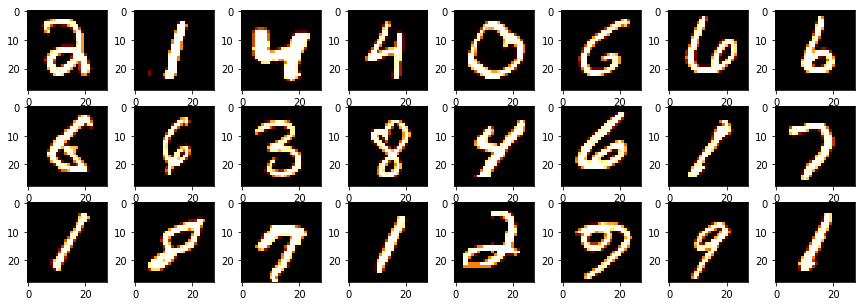

In [82]:
plt.figure(figsize = (15,5))
for i in range(24):
    plt.subplot(3,8,i+1)
    j = np.random.randint(0, len(df_train_image))
    plt.imshow(df_train_image[j].reshape(28,28), cmap='afmhot')

# Normalization
### Might be also changed to other normalization methods in order to see if it affects the prediction

In [284]:
# features normalisation
def normalize_grayscale(image_data):
    # Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    # you may also want to try to scale to [-1, 1] or just use keras Batchnormalisation layer
    return (image_data) / 255
train_features = normalize_grayscale(df_train_image)
test_features = normalize_grayscale(df_test_image)

In [285]:
#OneHotEncode labels
df_train_label = to_categorical(df_train_label)
df_test_label = to_categorical(df_test_label)

#Split dataset into train and validation 
X_train, X_val, y_train, y_val = train_test_split(train_features, df_train_label, test_size = 0.15, random_state=2)

#Print shape
print("Shape of validation set: {}".format(X_val.shape))
print("Shape of train set: {}".format(X_train.shape))
print("Shape of test set: {}".format(df_test_image.shape))
print(y_train.shape)

Shape of validation set: (6300, 28, 28, 1)
Shape of train set: (35700, 28, 28, 1)
Shape of test set: (28000, 28, 28, 1)
(35700, 10)


# Image augmentation

In [286]:
from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    width_shift_range=0.12,
    height_shift_range=0.12,
    rotation_range=0.12,
    zoom_range = 0.11)

datagen_valid = ImageDataGenerator(
    width_shift_range=0.12,
    height_shift_range=0.12,
    rotation_range=10,
    zoom_range = 0.11)

datagen_train.fit(X_train)
datagen_valid.fit(X_val)

# Build the CNN

In [287]:
def get_model(input_shape):
    
    drop = 0.3
    
    X_input = Input(input_shape)
    
    X = Conv2D(64, (5,5), strides=(1,1), activation='relu', padding='same',
               kernel_initializer='glorot_normal')(X_input)
    
    X = Conv2D(64, (5,5), strides=(1,1), activation='relu', padding='same',
               kernel_initializer='glorot_normal')(X_input)
    
    X = MaxPooling2D(pool_size=(2,2))(X)
    
    X = Conv2D(128, (3,3), strides=(1,1), activation='relu', padding='same',
              kernel_initializer='glorot_normal')(X)
    
    X = Conv2D(128, (3,3), strides=(1,1), activation='relu', padding='same',
              kernel_initializer='glorot_normal')(X)
    
    X = MaxPooling2D(pool_size = (2,2))(X)
    
    X = Flatten()(X)
    
    X = Dense(256, activation='relu')(X)
    X = Dropout(drop)(X)
    
    X = Dense(32, activation='relu')(X)
    X = Dropout(drop)(X)
    
    X = Dense(10, activation='softmax')(X)
    
    model = Model(inputs=[X_input], outputs=[X])
    
    return model

In [288]:
from keras.optimizers import Nadam
#opt = Nadam(lr=0.001)
opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model

In [289]:
model = get_model((28, 28, 1))
# compile the model
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 6272)              0         
__________

# Train the model

In [290]:
# train the model
batch_size = 64
epochs = 15

checkpointer = ModelCheckpoint(filepath='model.weights.new.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(X_train, y_train, batch_size), 
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs, callbacks = [checkpointer],
                    validation_data=datagen_valid.flow(X_val, y_val,batch_size),
                    validation_steps=X_val.shape[0] // batch_size, 
                    verbose=2, shuffle=True)

Epoch 1/15
Epoch 00001: val_loss improved from inf to 0.16819, saving model to model.weights.new.hdf5
 - 401s - loss: 0.5979 - acc: 0.8112 - val_loss: 0.1682 - val_acc: 0.9530
Epoch 2/15
Epoch 00002: val_loss improved from 0.16819 to 0.13803, saving model to model.weights.new.hdf5
 - 420s - loss: 0.1976 - acc: 0.9483 - val_loss: 0.1380 - val_acc: 0.9636
Epoch 3/15
Epoch 00003: val_loss did not improve
 - 396s - loss: 0.1642 - acc: 0.9584 - val_loss: 0.1385 - val_acc: 0.9667
Epoch 4/15
Epoch 00004: val_loss did not improve
 - 389s - loss: 0.1516 - acc: 0.9631 - val_loss: 0.1398 - val_acc: 0.9646
Epoch 5/15
Epoch 00005: val_loss improved from 0.13803 to 0.12499, saving model to model.weights.new.hdf5
 - 391s - loss: 0.1622 - acc: 0.9633 - val_loss: 0.1250 - val_acc: 0.9640
Epoch 6/15
Epoch 00006: val_loss did not improve
 - 389s - loss: 0.1545 - acc: 0.9649 - val_loss: 0.1387 - val_acc: 0.9657
Epoch 7/15
Epoch 00007: val_loss improved from 0.12499 to 0.11334, saving model to model.weight

In [291]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.new.hdf5')

In [292]:
# evaluate and print test accuracy
pred = model.predict(test_features, batch_size=64, verbose=1)
pred_digits = np.argmax(pred, axis=1)

28000/28000 [==============================] - 95s 3ms/step


In [293]:
import datetime
today = str(datetime.datetime.now().strftime("%Y-%B-%d-%H-%M"))
submission = pd.DataFrame({'Label': pred_digits})
submission.index += 1
submission.index.name = "ImageId"
submission.to_csv('submission'+ today + '.csv')

In [238]:
y = np.append(y_train, to_categorical(pred_digits), 0)
X = np.append(X_train, test_features,0)

In [240]:
# train the model
batch_size = 64

checkpointer = ModelCheckpoint(filepath='model.weights.rmsle.best_merge.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(X, y, batch_size), 
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=30, callbacks = [checkpointer],
                    validation_data=datagen_valid.flow(X_val, y_val,batch_size),
                    validation_steps=X_val.shape[0] // batch_size, 
                    verbose=2, shuffle=True)

Epoch 1/30
Epoch 00001: val_loss improved from inf to 0.46744, saving model to model.weights.rmsle.best_merge.hdf5
 - 154s - loss: 0.4929 - acc: 0.9129 - val_loss: 0.4674 - val_acc: 0.9405
Epoch 2/30
Epoch 00002: val_loss improved from 0.46744 to 0.46046, saving model to model.weights.rmsle.best_merge.hdf5
 - 148s - loss: 0.5450 - acc: 0.9032 - val_loss: 0.4605 - val_acc: 0.9225
Epoch 3/30
Epoch 00003: val_loss did not improve
 - 161s - loss: 0.5595 - acc: 0.9045 - val_loss: 0.5798 - val_acc: 0.8798
Epoch 4/30
Epoch 00004: val_loss did not improve
 - 150s - loss: 0.5897 - acc: 0.8996 - val_loss: 0.4998 - val_acc: 0.9305
Epoch 5/30
Epoch 00005: val_loss did not improve
 - 150s - loss: 0.5930 - acc: 0.8998 - val_loss: 0.5578 - val_acc: 0.9224
Epoch 6/30
Epoch 00006: val_loss improved from 0.46046 to 0.37383, saving model to model.weights.rmsle.best_merge.hdf5
 - 148s - loss: 0.6453 - acc: 0.8981 - val_loss: 0.3738 - val_acc: 0.9318
Epoch 7/30
Epoch 00007: val_loss did not improve
 - 153s